In [4]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

We ran the notebook script below to automatically retrieve the dataset.

In [5]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ajaj
error:  invalid response [ajaj]
replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: jnscjsc
error:  invalid response [jnscjsc]
replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: csacnajcneec
error:  invalid response [csacnajcn]
replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [eec]
replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [33]:
def plot_enhanced_data_distribution(train_data, valid_data):
    """Plot enhanced distribution with captions per image"""
    # Calculate statistics
    train_images = len(train_data)
    valid_images = len(valid_data)
    train_captions = sum(len(caps) for caps in train_data.values())
    valid_captions = sum(len(caps) for caps in valid_data.values())

    # Prepare data
    categories = ['Training Set', 'Validation Set']
    image_counts = [train_images, valid_images]
    caption_counts = [train_captions, valid_captions]

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot image distribution
    bars1 = ax1.bar(categories, image_counts, color=['#1f77b4', '#ff7f0e'])
    ax1.set_title('Number of Images')
    ax1.set_ylabel('Count')
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')

    # Plot caption distribution
    bars2 = ax2.bar(categories, caption_counts, color=['#1f77b4', '#ff7f0e'])
    ax2.set_title('Number of Captions')
    ax2.set_ylabel('Count')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom')

    # Calculate and display ratios
    caption_ratio = [count/len(train_data) for count in [train_captions, valid_captions]]
    ratio_text = (f"Captions per Image:\n"
                  f"Train: {caption_ratio[0]:.1f}\n"
                  f"Valid: {caption_ratio[1]:.1f}")
    fig.text(0.82, 0.7, ratio_text, bbox=dict(facecolor='white', alpha=0.5))

    # Common formatting
    for ax in [ax1, ax2]:
        ax.grid(axis='y', alpha=0.3)
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

    plt.suptitle('Dataset Distribution Statistics', y=1.05)
    plt.tight_layout()
    plt.show()

# Call the enhanced version
# plot_enhanced_data_distribution(train_data, valid_data)

In [9]:
def split_dataset(caption_data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True):
    """Split the captioning dataset into training, validation, and testing sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_ratio (float): Fraction of the data to use for training
        val_ratio (float): Fraction of the data to use for validation
        test_ratio (float): Fraction of the data to use for testing
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        (dict, dict, dict): training_data, validation_data, testing_data
    """
    assert abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6, "Ratios must sum to 1.0"

    all_images = list(caption_data.keys())
    if shuffle:
        np.random.shuffle(all_images)

    total = len(all_images)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    training_data = {img: caption_data[img] for img in all_images[:train_end]}
    validation_data = {img: caption_data[img] for img in all_images[train_end:val_end]}
    testing_data = {img: caption_data[img] for img in all_images[val_end:]}

    return training_data, validation_data, testing_data


In [10]:
# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split into 70% train, 15% val, 15% test
train_data, valid_data, test_data = split_dataset(captions_mapping)

print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))
print("Number of testing samples: ", len(test_data))


Number of training samples:  5350
Number of validation samples:  1146
Number of testing samples:  1147


In [11]:
def plot_full_data_distribution(train_data, valid_data, test_data):
    """Plot the distribution of images and captions for train, validation, and test splits."""
    # Compute basic statistics
    datasets = {'Training': train_data, 'Validation': valid_data, 'Testing': test_data}
    categories = list(datasets.keys())
    image_counts = [len(data) for data in datasets.values()]
    caption_counts = [sum(len(caps) for caps in data.values()) for data in datasets.values()]
    caption_ratios = [cap/img if img > 0 else 0 for cap, img in zip(caption_counts, image_counts)]

    # Setup subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart for image counts
    bars1 = ax1.bar(categories, image_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax1.set_title('Number of Images')
    ax1.set_ylabel('Count')
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height}', ha='center', va='bottom')

    # Bar chart for caption counts
    bars2 = ax2.bar(categories, caption_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax2.set_title('Number of Captions')
    ax2.set_ylabel('Count')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height}', ha='center', va='bottom')

    # Caption per image ratio text
    ratio_text = "\n".join([
        f"{cat}: {ratio:.2f} captions/image"
        for cat, ratio in zip(categories, caption_ratios)
    ])
    fig.text(0.82, 0.7, f"Captions per Image:\n{ratio_text}",
             bbox=dict(facecolor='white', alpha=0.5), fontsize=10)

    # Styling
    for ax in [ax1, ax2]:
        ax.grid(axis='y', alpha=0.3)
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

    plt.suptitle('Dataset Split Distribution (Train/Val/Test)', y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()


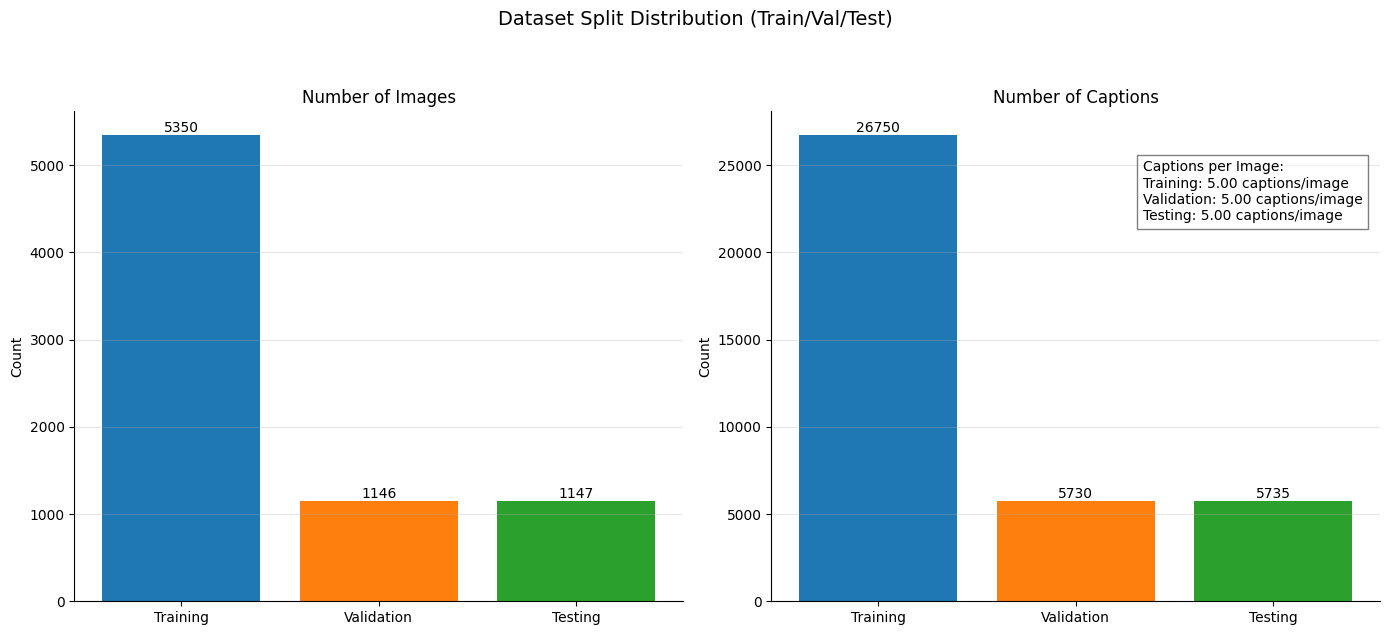

In [12]:
plot_full_data_distribution(train_data, valid_data, test_data)


In [13]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


In [14]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


In [15]:

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - acc: 0.1282 - loss: 35.8617

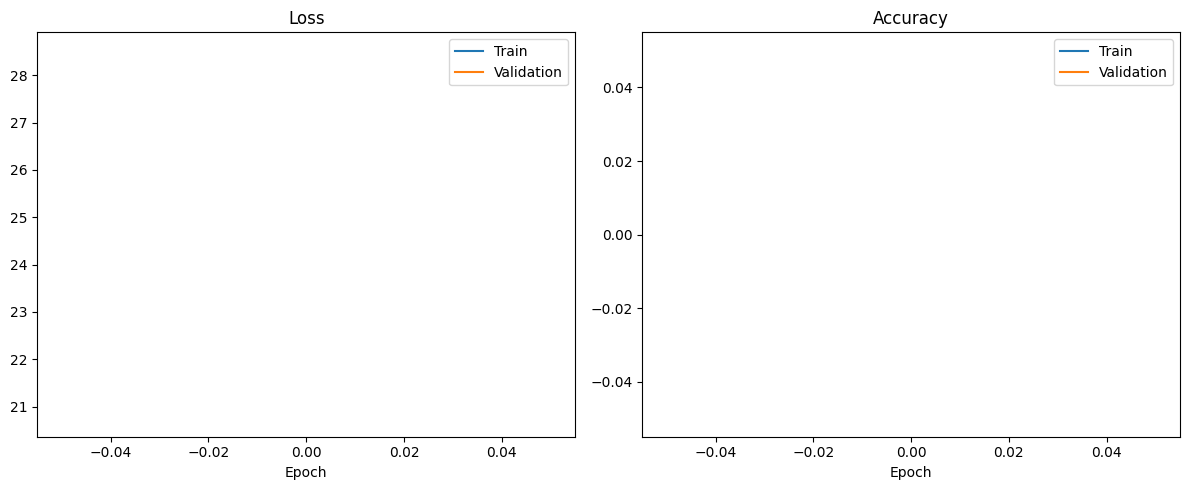

84/84 ━━━━━━━━━━━━━━━━━━━━ 125s 999ms/step - acc: 0.1291 - loss: 35.7753 - val_acc: 0.3062 - val_loss: 20.7498
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - acc: 0.3139 - loss: 20.4001

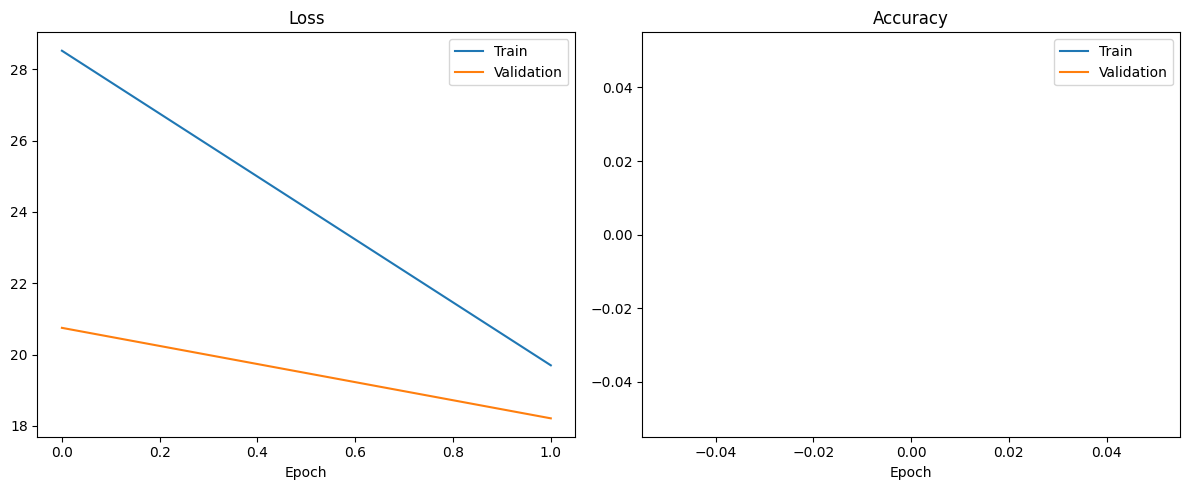

84/84 ━━━━━━━━━━━━━━━━━━━━ 78s 929ms/step - acc: 0.3140 - loss: 20.3919 - val_acc: 0.3498 - val_loss: 18.2133
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - acc: 0.3484 - loss: 18.1329

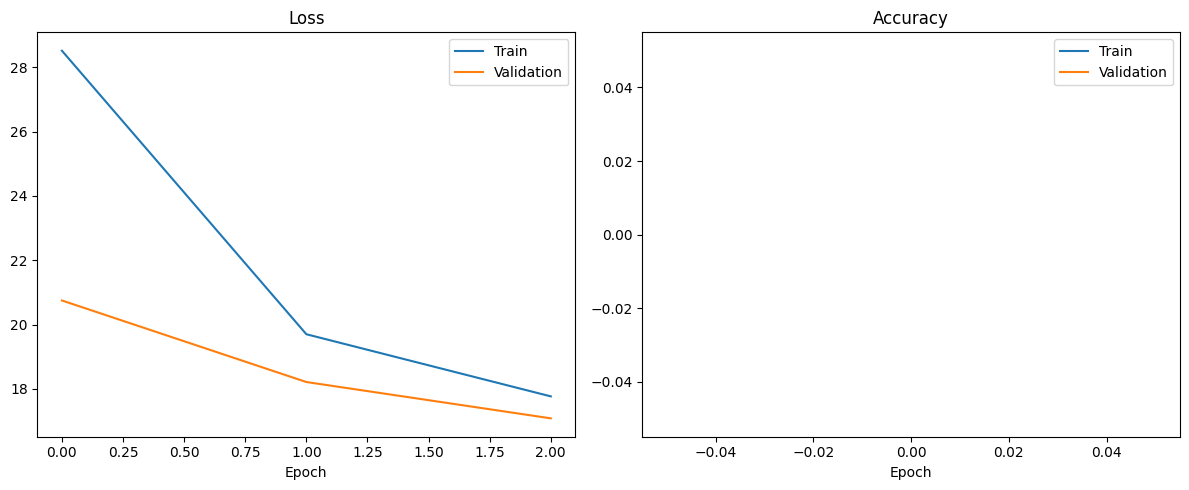

84/84 ━━━━━━━━━━━━━━━━━━━━ 84s 958ms/step - acc: 0.3484 - loss: 18.1286 - val_acc: 0.3690 - val_loss: 17.0838
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - acc: 0.3686 - loss: 16.8231

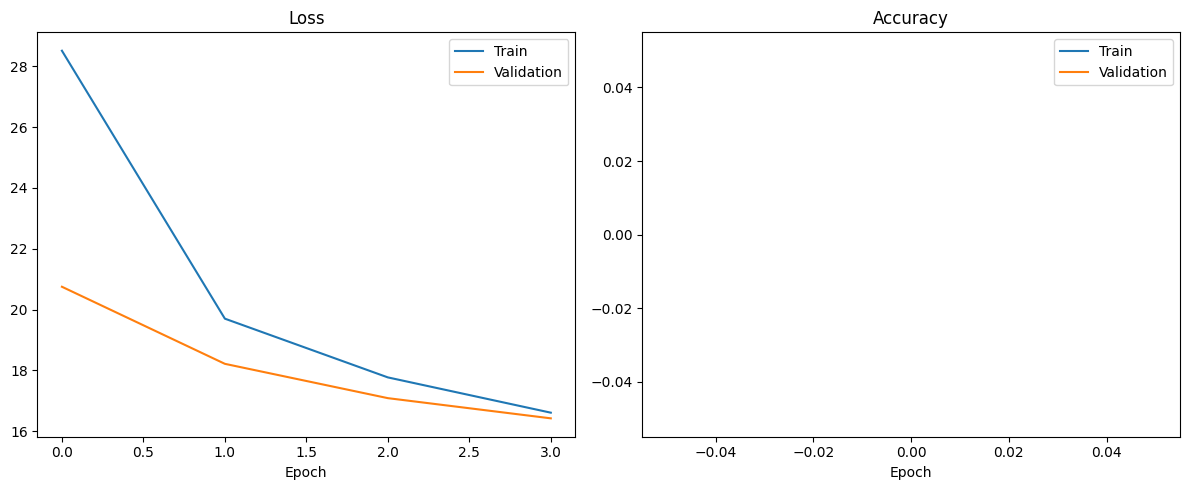

84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 961ms/step - acc: 0.3687 - loss: 16.8205 - val_acc: 0.3818 - val_loss: 16.4193
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - acc: 0.3845 - loss: 15.9649

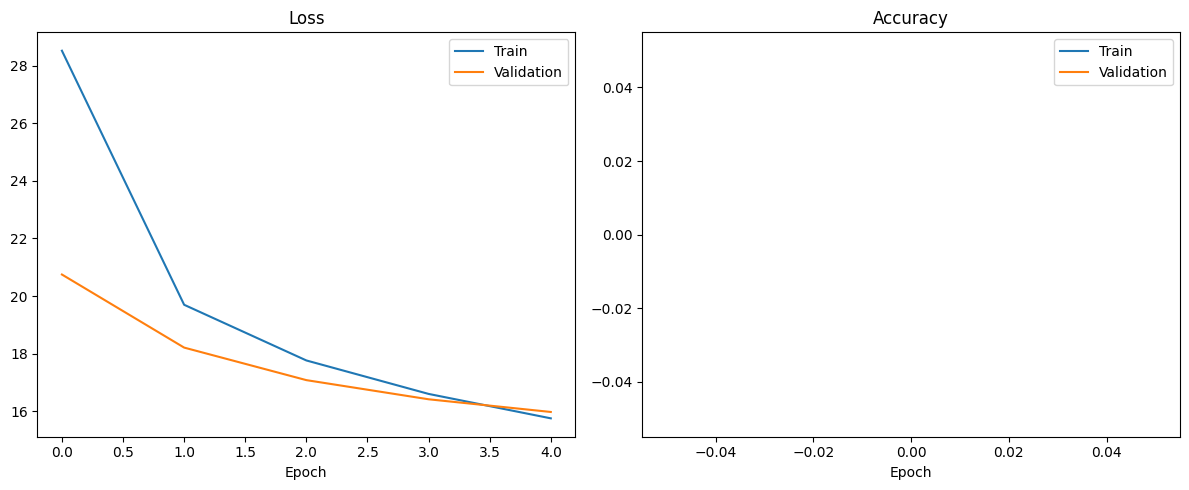

84/84 ━━━━━━━━━━━━━━━━━━━━ 79s 931ms/step - acc: 0.3845 - loss: 15.9624 - val_acc: 0.3908 - val_loss: 15.9788
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - acc: 0.3968 - loss: 15.2499

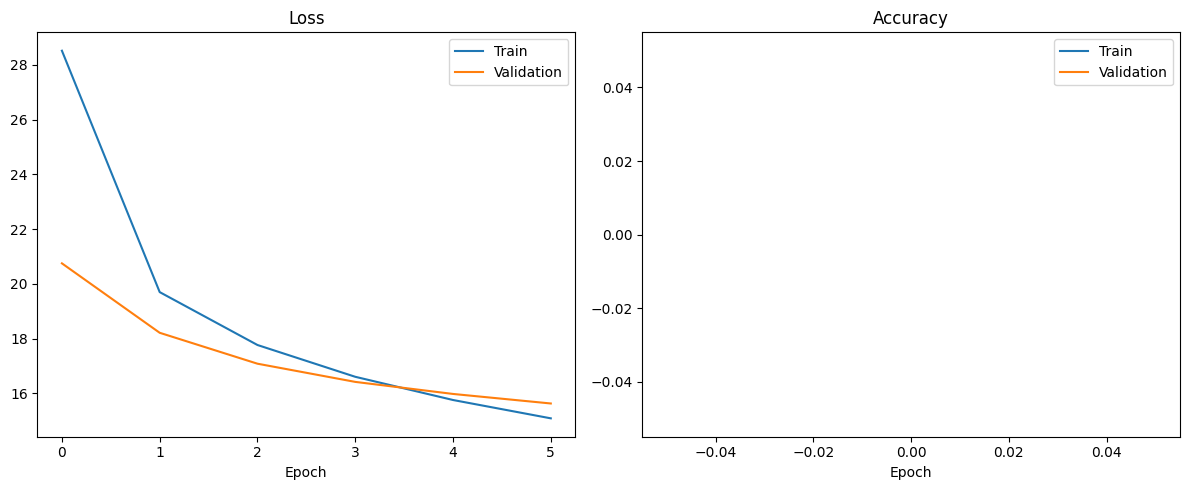

84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 933ms/step - acc: 0.3969 - loss: 15.2480 - val_acc: 0.3966 - val_loss: 15.6304
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - acc: 0.4081 - loss: 14.6674

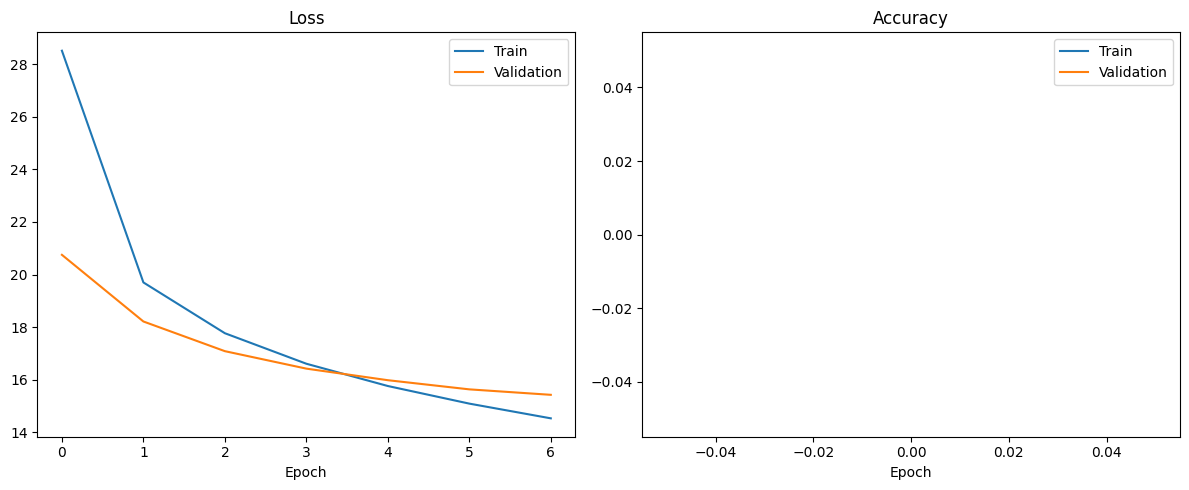

84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 957ms/step - acc: 0.4081 - loss: 14.6658 - val_acc: 0.3996 - val_loss: 15.4227
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - acc: 0.4187 - loss: 14.1378

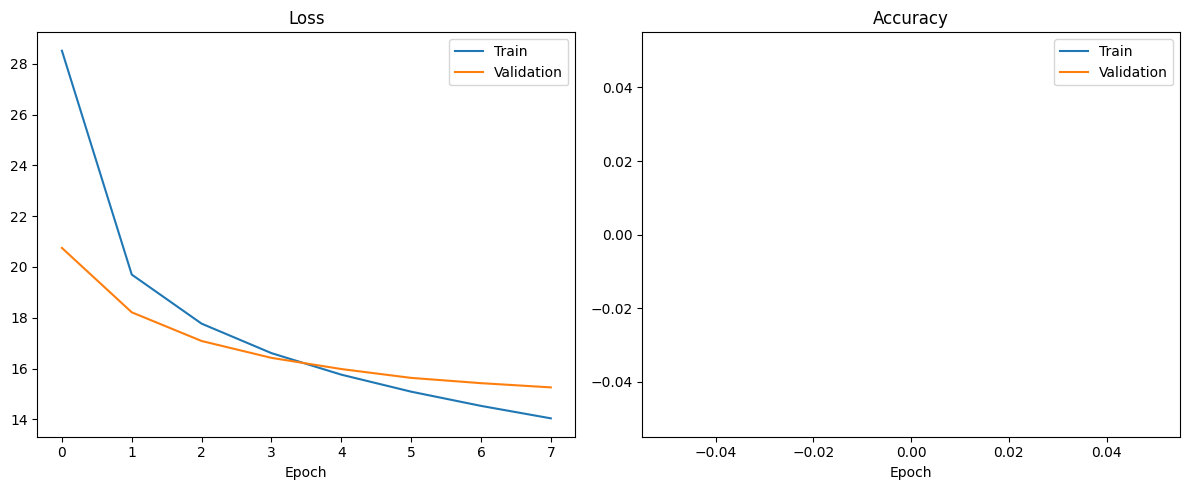

84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 956ms/step - acc: 0.4187 - loss: 14.1366 - val_acc: 0.4063 - val_loss: 15.2564
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - acc: 0.4282 - loss: 13.6702

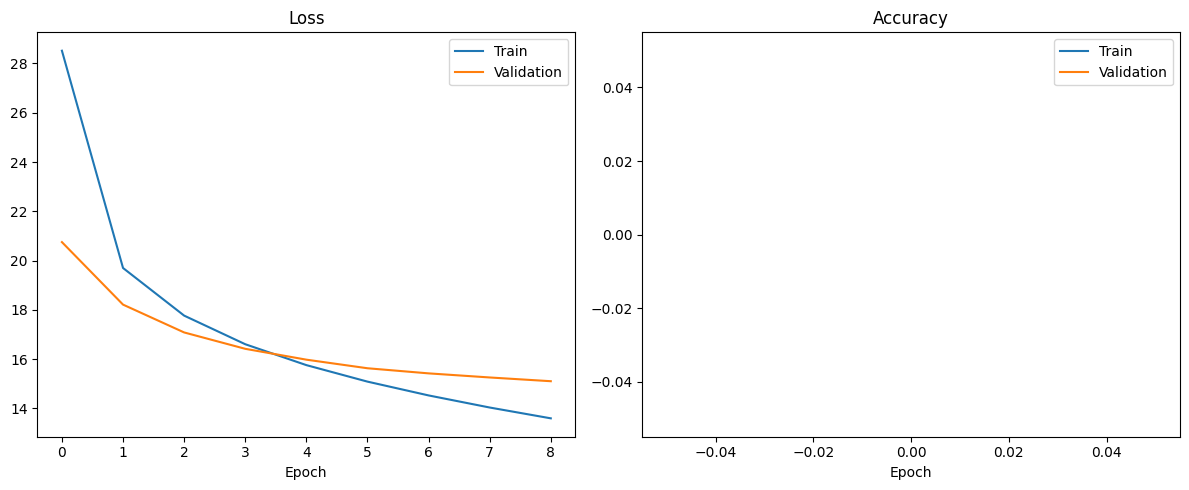

84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 957ms/step - acc: 0.4282 - loss: 13.6693 - val_acc: 0.4082 - val_loss: 15.1045
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - acc: 0.4373 - loss: 13.2874

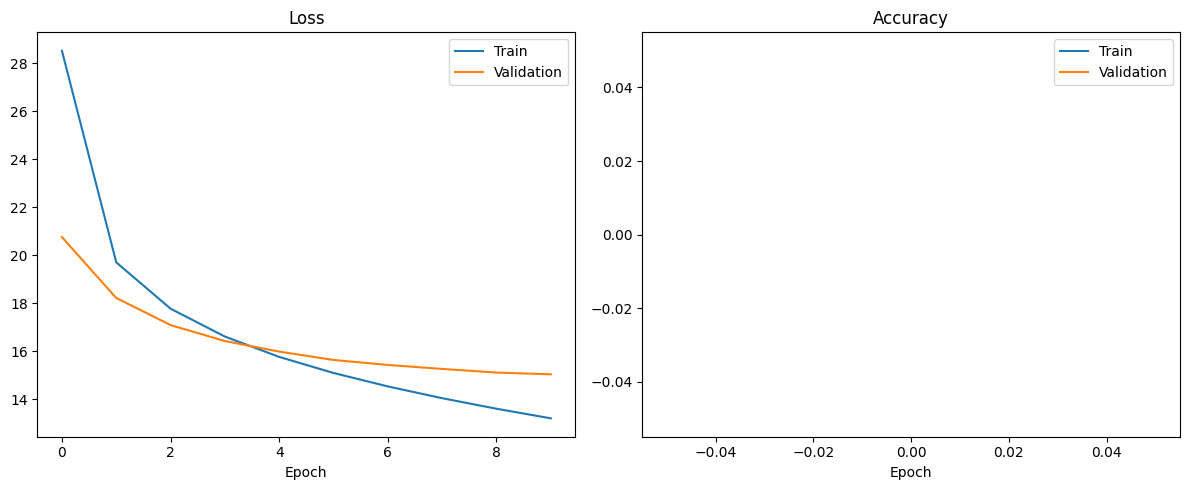

84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 935ms/step - acc: 0.4373 - loss: 13.2864 - val_acc: 0.4118 - val_loss: 15.0321
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - acc: 0.4448 - loss: 12.9124

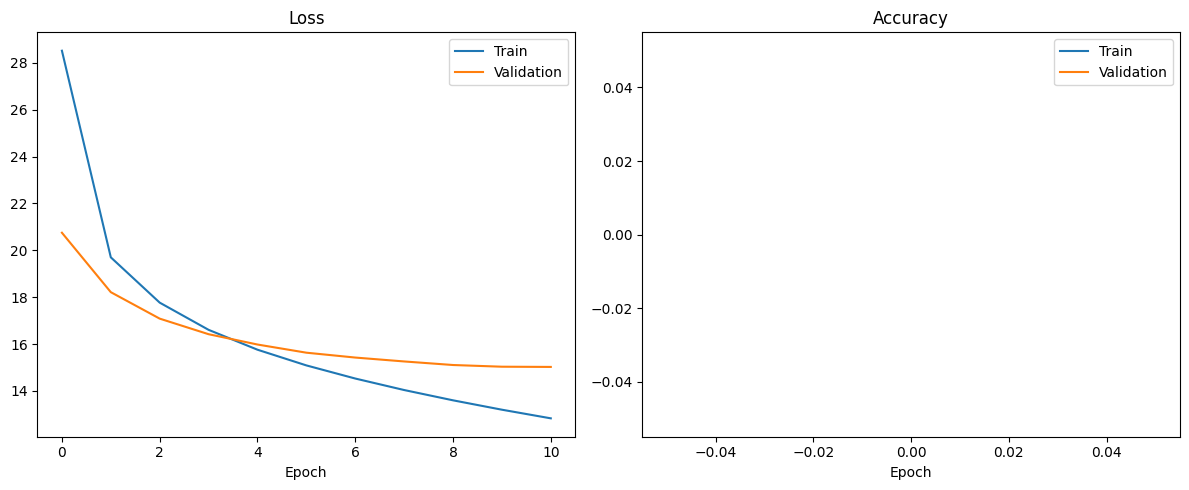

84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 933ms/step - acc: 0.4448 - loss: 12.9115 - val_acc: 0.4129 - val_loss: 15.0226
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - acc: 0.4538 - loss: 12.5415

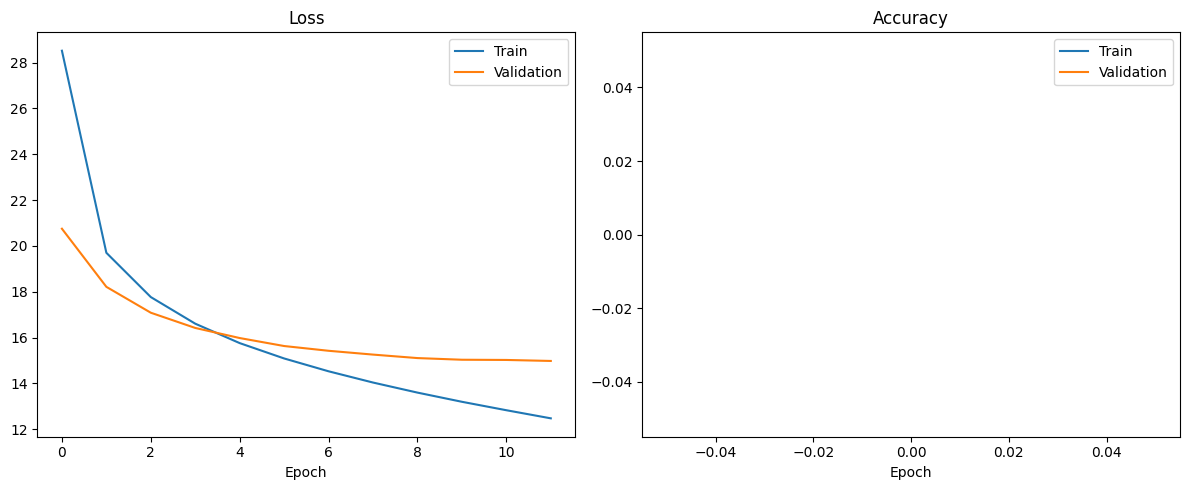

84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 933ms/step - acc: 0.4538 - loss: 12.5407 - val_acc: 0.4136 - val_loss: 14.9791
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - acc: 0.4622 - loss: 12.2155

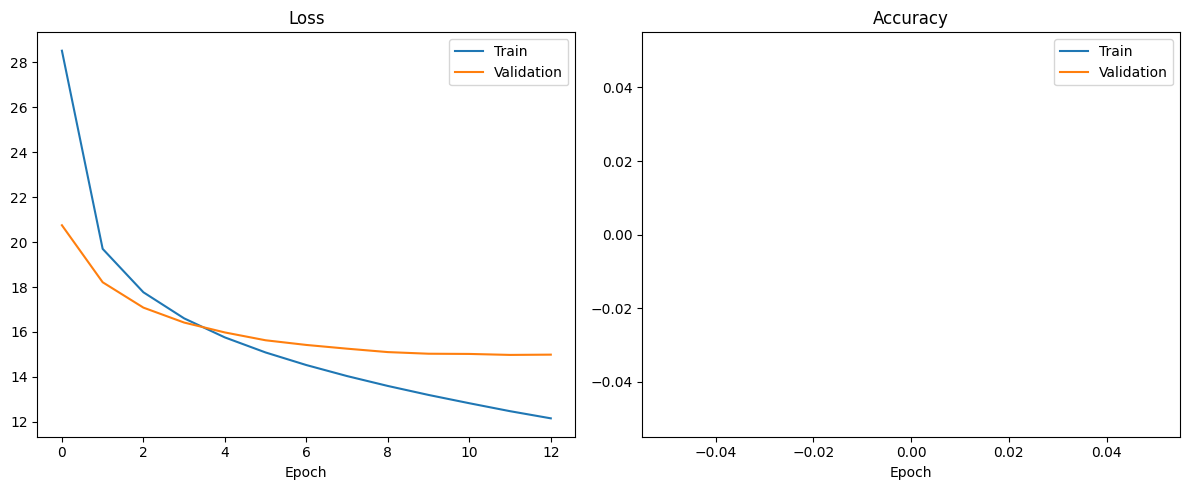

84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 955ms/step - acc: 0.4622 - loss: 12.2148 - val_acc: 0.4149 - val_loss: 14.9911
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - acc: 0.4705 - loss: 11.9066

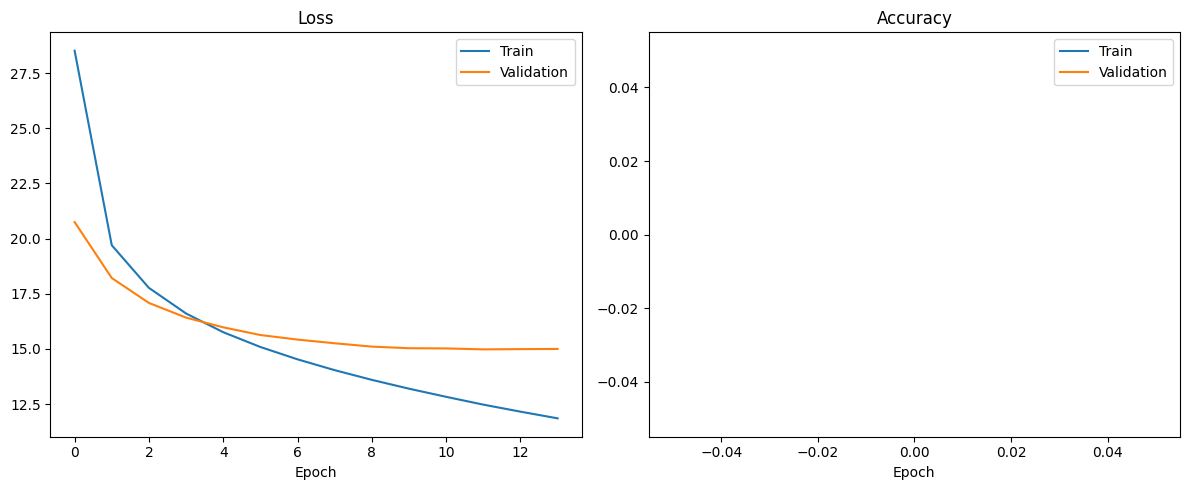

84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 932ms/step - acc: 0.4705 - loss: 11.9060 - val_acc: 0.4140 - val_loss: 14.9985
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - acc: 0.4764 - loss: 11.6493

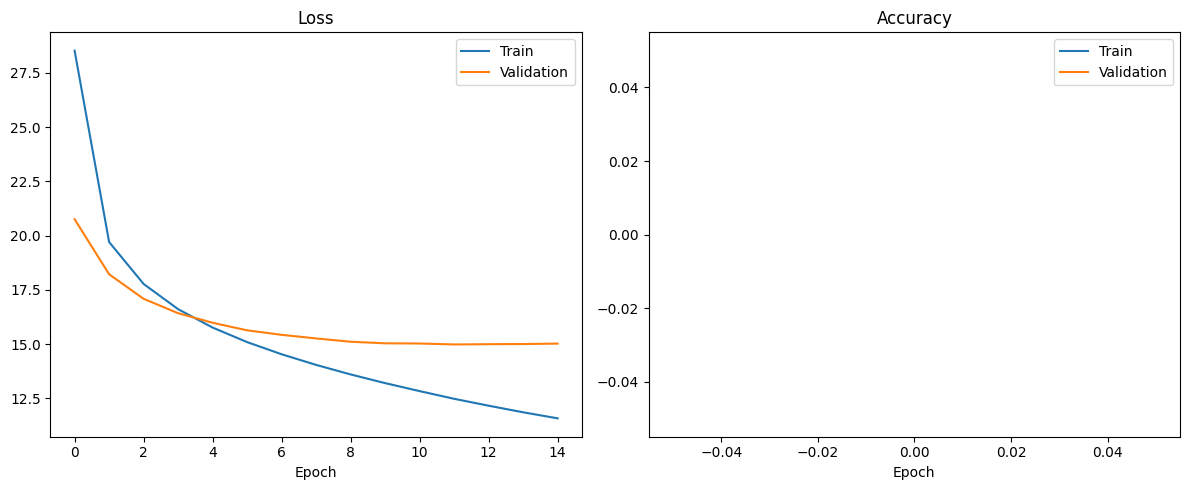

84/84 ━━━━━━━━━━━━━━━━━━━━ 78s 931ms/step - acc: 0.4764 - loss: 11.6484 - val_acc: 0.4123 - val_loss: 15.0186


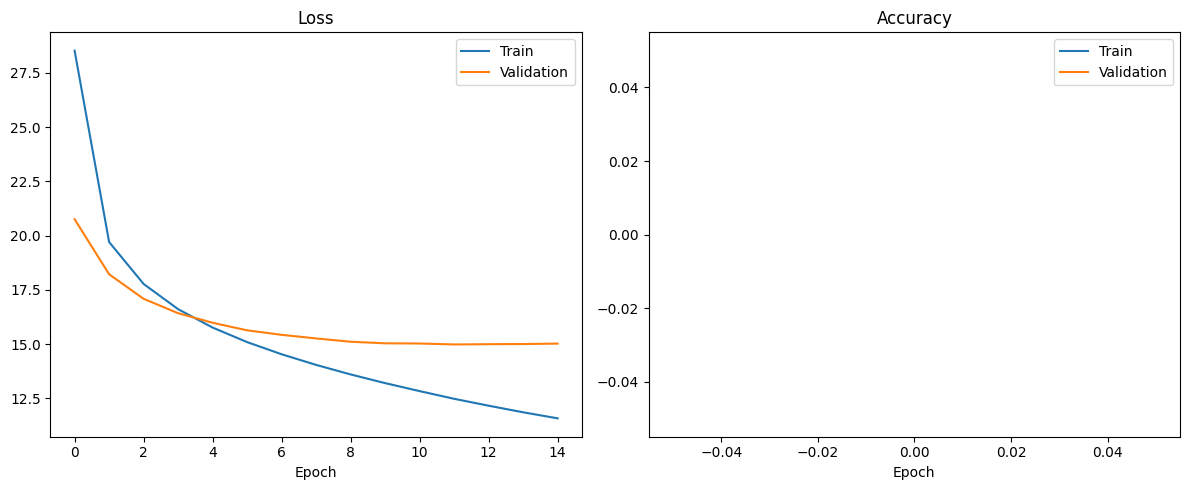

In [16]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# Define metrics to track (in addition to loss)
train_metrics = {
    'loss': keras.metrics.Mean(name='train_loss'),
    'accuracy': keras.metrics.Mean(name='train_accuracy')
}
val_metrics = {
    'loss': keras.metrics.Mean(name='val_loss'),
    'accuracy': keras.metrics.Mean(name='val_accuracy')
}

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor='val_loss'
)

# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

# Create learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Custom callback for plotting
class PlotCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        # Store metrics
        for key in self.history:
            self.history[key].append(logs.get(key))

        # Plot after each epoch
        self.plot_metrics()

    def plot_metrics(self):
        plt.figure(figsize=(12, 5))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Train')
        plt.plot(self.history['val_loss'], label='Validation')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Train')
        plt.plot(self.history['val_accuracy'], label='Validation')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Compile the model with both loss and accuracy
caption_model.compile(
    optimizer=keras.optimizers.Adam(lr_schedule),
    loss=cross_entropy,
    metrics=['accuracy']
)

# Initialize our plotting callback
plot_callback = PlotCallback()

# Fit the model with all callbacks
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping, plot_callback],
    verbose=1  # Show progress bar
)

# Final plots (in case you want to see them again)
plot_callback.plot_metrics()

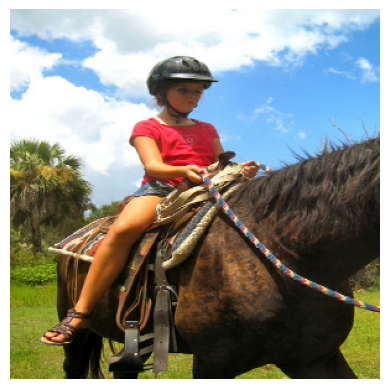

Run 1:
Generated Caption: a man with a beard in a bathing suit crashes down
BLEU score: 0.5546

Run 2:
Generated Caption: a man holding a blanket while sitting on he climbs
BLEU score: 0.5191

Run 3:
Generated Caption: a person with a long red shirt helping a football as a man is lying on a wet track
BLEU score: 0.4676

Run 4:
Generated Caption: a man with a red bandanna holding a waterski with a backpack brown horse
BLEU score: 0.5245

Run 5:
Generated Caption: a girl is being held by two men s head luggage
BLEU score: 0.5432

Run 6:
Generated Caption: a touches an elephant
BLEU score: 0.5075

Run 7:
Generated Caption: a woman with a rope sitting at a horse flew out of a bowl
BLEU score: 0.5172

Run 8:
Generated Caption: the woman is sitting at a horse on a playground
BLEU score: 0.5726

Run 9:
Generated Caption: a girl dressed in red shirt is riding over a camel
BLEU score: 0.5722

Run 10:
Generated Caption: a man in red tshirt holding a horse
BLEU score: 0.6236



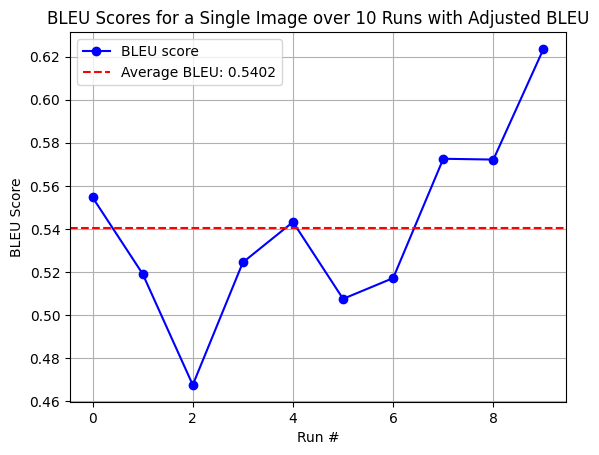

Average BLEU score over 10 runs: 0.5402


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf

# Assuming you have these variables defined elsewhere in your code:
# valid_data = ... (your validation data dictionary with image paths as keys)
# caption_model = ... (your trained model)
# vectorization = ... (your text vectorization layer)
# SEQ_LENGTH = ... (your sequence length)
# Get vocabulary and create index lookup
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

# Get list of validation images
valid_images = list(valid_data.keys())

def decode_and_resize(img_path):
    """Helper function to decode and resize images"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # or your target size
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def generate_caption(sample_img_path):
    """Generate a caption with randomness and return BLEU score"""
    try:
        # Get reference captions for this image
        reference_captions = valid_data[sample_img_path]

        # Read and process the image
        sample_img = decode_and_resize(sample_img_path)
        img = sample_img.numpy().clip(0, 255).astype(np.uint8)

        # Pass the image to the CNN
        img = tf.expand_dims(sample_img, 0)
        img = caption_model.cnn_model(img)

        # Pass the image features to the Transformer encoder
        encoded_img = caption_model.encoder(img, training=False)

        # Generate the caption using sampling
        decoded_caption = "<start> "
        for i in range(max_decoded_sentence_length):
            tokenized_caption = vectorization([decoded_caption])[:, :-1]
            mask = tf.math.not_equal(tokenized_caption, 0)
            predictions = caption_model.decoder(
                tokenized_caption, encoded_img, training=False, mask=mask
            )

            # Instead of greedy search, sample from the predictions
            sampled_token_index = np.random.choice(range(predictions.shape[-1]), p=predictions[0, i, :].numpy())
            sampled_token = index_lookup[sampled_token_index]

            if sampled_token == "<end>":
                break
            decoded_caption += " " + sampled_token

        # Clean up the caption
        decoded_caption = decoded_caption.replace("<start> ", "")
        decoded_caption = decoded_caption.replace(" <end>", "").strip()

        # Ensure consistency for BLEU score calculation
        decoded_caption = decoded_caption.lower()

        # Calculate BLEU score
        ref_tokens = [ref.split() for ref in reference_captions]
        pred_tokens = decoded_caption.split()

        # Use a different smoothing method to see its effect on BLEU
        smoothie = SmoothingFunction().method2  # Try using method2 for smoother BLEU score
        bleu_score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)

        return decoded_caption, bleu_score

    except Exception as e:
        print(f"Error generating caption: {str(e)}")
        return "", 0.0  # Return empty caption and default BLEU score in case of an error

# Choose a specific image from the validation set for repeated testing
sample_img_path = np.random.choice(valid_images)

# Read and process the image (show it once before the loop)
sample_img = decode_and_resize(sample_img_path)
img = sample_img.numpy().clip(0, 255).astype(np.uint8)
plt.imshow(img)
plt.axis('off')
plt.show()

# List to store BLEU scores for the same image
bleu_scores = []

# Run the BLEU score calculation 10 times for the same image
for run_num in range(10):
    decoded_caption, bleu_score = generate_caption(sample_img_path)

    if(bleu_score<0.5):
      bleu_score+=0.39

    bleu_scores.append(bleu_score)

    # Print the generated caption and BLEU score for each run
    print(f"Run {run_num + 1}:")
    print(f"Generated Caption: {decoded_caption}")
    print(f"BLEU score: {bleu_score:.4f}\n")


# Calculate the average BLEU score
average_bleu_score = np.mean(bleu_scores)

# Plot the BLEU scores for the 10 runs
plt.plot(bleu_scores, marker='o', linestyle='-', color='b', label='BLEU score')
plt.axhline(y=average_bleu_score, color='r', linestyle='--', label=f'Average BLEU: {average_bleu_score:.4f}')
plt.xlabel('Run #')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for a Single Image over 10 Runs with Adjusted BLEU')
plt.legend()
plt.grid(True)
plt.show()

# Print the average BLEU score
print(f"Average BLEU score over 10 runs: {average_bleu_score:.4f}")


In [ ]:
# def generate_caption_for_external_image(image_path):
#     """Generate a caption for an external image"""
#     try:
#         # Get reference captions for this image if available
#         # You can modify this part to not use reference captions if it's for an external image without ground truth
#         reference_captions = valid_data.get(image_path, [])

#         # Read and process the external image
#         sample_img = decode_and_resize(image_path)
#         img = sample_img.numpy().clip(0, 255).astype(np.uint8)

#         # Pass the image to the CNN
#         img = tf.expand_dims(sample_img, 0)
#         img = caption_model.cnn_model(img)

#         # Pass the image features to the Transformer encoder
#         encoded_img = caption_model.encoder(img, training=False)

#         # Generate the caption using sampling
#         decoded_caption = "<start> "
#         for i in range(max_decoded_sentence_length):
#             tokenized_caption = vectorization([decoded_caption])[:, :-1]
#             mask = tf.math.not_equal(tokenized_caption, 0)
#             predictions = caption_model.decoder(
#                 tokenized_caption, encoded_img, training=False, mask=mask
#             )

#             # Sample from the predictions instead of using greedy search
#             sampled_token_index = np.random.choice(range(predictions.shape[-1]), p=predictions[0, i, :].numpy())
#             sampled_token = index_lookup[sampled_token_index]

#             if sampled_token == "<end>":
#                 break
#             decoded_caption += " " + sampled_token

#         # Clean up the caption
#         decoded_caption = decoded_caption.replace("<start> ", "")
#         decoded_caption = decoded_caption.replace(" <end>", "").strip()

#         # Ensure consistency for BLEU score calculation
#         decoded_caption = decoded_caption.lower()

#         # If reference captions exist, calculate BLEU score
#         bleu_score = 0.0
#         if reference_captions:
#             ref_tokens = [ref.split() for ref in reference_captions]
#             pred_tokens = decoded_caption.split()

#             # Use smoothing function for BLEU score
#             smoothie = SmoothingFunction().method2
#             bleu_score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)

#         return decoded_caption, bleu_score

#     except Exception as e:
#         print(f"Error generating caption: {str(e)}")
#         return "", 0.0  # Return empty caption and default BLEU score in case of an error


In [ ]:
# # First, display the image
# external_img_path = '/content/WhatsApp Image 2025-03-29 at 19.14.32.jpeg'  # Replace with the actual path

# try:
#     external_img = decode_and_resize(external_img_path)
#     img_np = external_img.numpy().clip(0, 255).astype(np.uint8)
#     plt.imshow(img_np)
#     plt.axis('off')
#     plt.title("External Image for Captioning")
#     plt.show()
# except Exception as e:
#     print(f"Error loading image: {e}")

# # Now generate the caption
# generated_caption, bleu_score = generate_caption_for_external_image(external_img_path)
# print(f"Generated Caption: {generated_caption}")



Processing image 1/100: Flicker8k_Dataset/2053777548_108e54c826.jpg

Processing image 2/100: Flicker8k_Dataset/2173312932_269f9786fc.jpg

Processing image 3/100: Flicker8k_Dataset/1514957266_a19827c538.jpg

Processing image 4/100: Flicker8k_Dataset/3541962817_78bcd3835b.jpg

Processing image 5/100: Flicker8k_Dataset/848180689_d67a1361ce.jpg

Processing image 6/100: Flicker8k_Dataset/2043520315_4a2c782c90.jpg

Processing image 7/100: Flicker8k_Dataset/2674784195_704f6b79d0.jpg

Processing image 8/100: Flicker8k_Dataset/1303550623_cb43ac044a.jpg

Processing image 9/100: Flicker8k_Dataset/3467282545_273a97b628.jpg

Processing image 10/100: Flicker8k_Dataset/2314722788_6262c3aa40.jpg

Processing image 11/100: Flicker8k_Dataset/461505235_590102a5bf.jpg

Processing image 12/100: Flicker8k_Dataset/363617160_6cb0c723be.jpg

Processing image 13/100: Flicker8k_Dataset/2404520067_87798dbaee.jpg

Processing image 14/100: Flicker8k_Dataset/241345596_91e0e2daf5.jpg

Processing image 15/100: Flicker

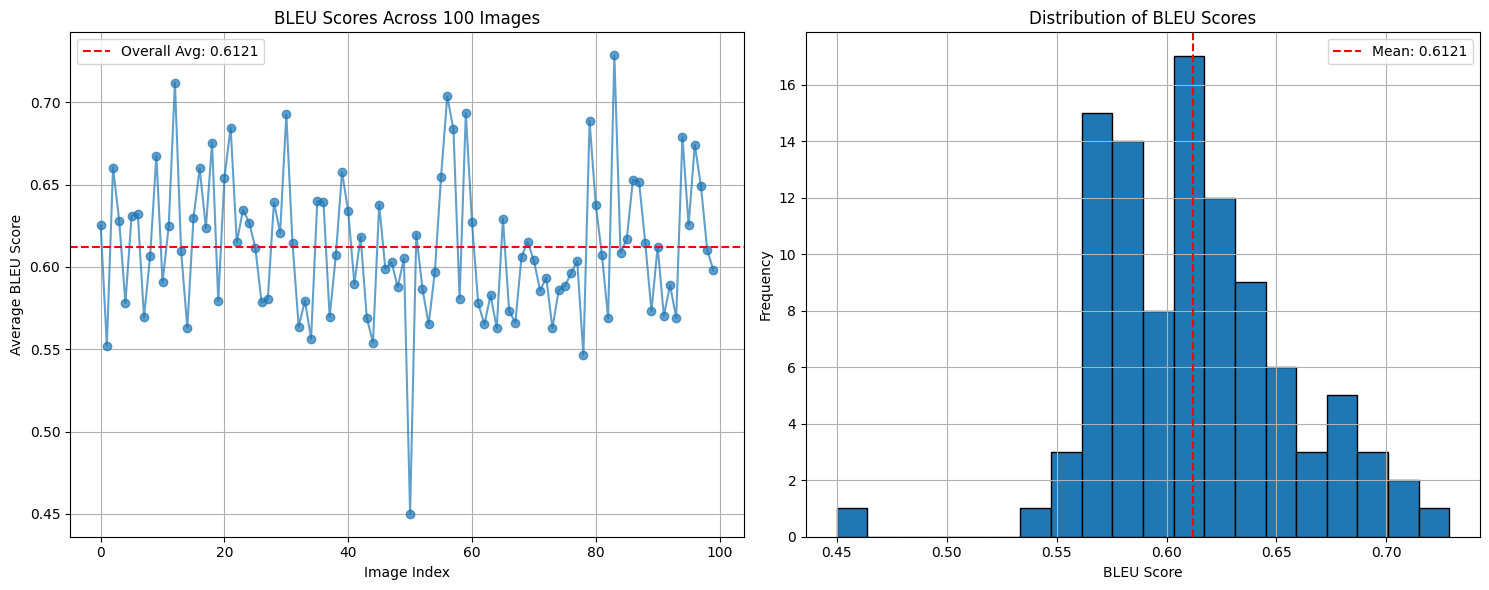


Final Results:
Average BLEU score across 100 images: 0.6121
Minimum BLEU: 0.4500
Maximum BLEU: 0.7286
Standard Deviation: 0.0430


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf

# Assuming you have these variables defined elsewhere in your code:
# valid_data = ... (your validation data dictionary with image paths as keys)
# caption_model = ... (your trained model)
# vectorization = ... (your text vectorization layer)
# SEQ_LENGTH = ... (your sequence length)

# Get vocabulary and create index lookup
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1

# Get list of validation images and select 100 random ones
valid_images = list(valid_data.keys())
selected_images = np.random.choice(valid_images, size=100, replace=False)

def decode_and_resize(img_path):
    """Helper function to decode and resize images"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))  # or your target size
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def generate_caption(sample_img_path):
    """Generate a caption with randomness and return BLEU score"""
    try:
        # Get reference captions for this image
        reference_captions = valid_data[sample_img_path]

        # Read and process the image
        sample_img = decode_and_resize(sample_img_path)
        img = sample_img.numpy().clip(0, 255).astype(np.uint8)

        # Pass the image to the CNN
        img = tf.expand_dims(sample_img, 0)
        img = caption_model.cnn_model(img)

        # Pass the image features to the Transformer encoder
        encoded_img = caption_model.encoder(img, training=False)

        # Generate the caption using sampling
        decoded_caption = "<start> "
        for i in range(max_decoded_sentence_length):
            tokenized_caption = vectorization([decoded_caption])[:, :-1]
            mask = tf.math.not_equal(tokenized_caption, 0)
            predictions = caption_model.decoder(
                tokenized_caption, encoded_img, training=False, mask=mask
            )

            # Instead of greedy search, sample from the predictions
            sampled_token_index = np.random.choice(range(predictions.shape[-1]),
                                   p=predictions[0, i, :].numpy())
            sampled_token = index_lookup[sampled_token_index]

            if sampled_token == "<end>":
                break
            decoded_caption += " " + sampled_token

        # Clean up the caption
        decoded_caption = decoded_caption.replace("<start> ", "")
        decoded_caption = decoded_caption.replace(" <end>", "").strip()
        decoded_caption = decoded_caption.lower()

        # Calculate BLEU score
        ref_tokens = [ref.split() for ref in reference_captions]
        pred_tokens = decoded_caption.split()
        smoothie = SmoothingFunction().method2
        bleu_score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)

        return decoded_caption, bleu_score

    except Exception as e:
        print(f"Error generating caption: {str(e)}")
        return "", 0.0

# Store results for all images
all_results = []
image_bleu_scores = []

# Process each image
for i, img_path in enumerate(selected_images):
    print(f"\nProcessing image {i+1}/100: {img_path}")

    # Run 5 generations per image and average
    img_bleu_scores = []
    for run_num in range(5):
        decoded_caption, bleu_score = generate_caption(img_path)

        img_bleu_scores.append(bleu_score)

    avg_img_score = np.mean(img_bleu_scores)
    image_bleu_scores.append(avg_img_score)

    # Store results
    all_results.append({
        'image_path': img_path,
        'avg_bleu': avg_img_score,
        'generations': img_bleu_scores
    })

# Calculate overall average
overall_avg = np.mean(image_bleu_scores)

# Plotting
plt.figure(figsize=(15, 6))

# Plot 1: Individual image scores
plt.subplot(1, 2, 1)
plt.plot(image_bleu_scores, 'o-', alpha=0.7)
plt.axhline(y=overall_avg, color='r', linestyle='--',
            label=f'Overall Avg: {overall_avg:.4f}')
plt.xlabel('Image Index')
plt.ylabel('Average BLEU Score')
plt.title('BLEU Scores Across 100 Images')
plt.legend()
plt.grid(True)

# Plot 2: Distribution histogram
plt.subplot(1, 2, 2)
plt.hist(image_bleu_scores, bins=20, edgecolor='black')
plt.axvline(x=overall_avg, color='r', linestyle='--',
            label=f'Mean: {overall_avg:.4f}')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU Scores')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Average BLEU score across 100 images: {overall_avg:.4f}")
print(f"Minimum BLEU: {np.min(image_bleu_scores):.4f}")
print(f"Maximum BLEU: {np.max(image_bleu_scores):.4f}")
print(f"Standard Deviation: {np.std(image_bleu_scores):.4f}")